<a href="https://colab.research.google.com/github/jellyXuuuuu/CovidNetDeepLearning/blob/main/1covid19model_ex_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare for package

In [ ]:
# !python --version

In [ ]:
# %%bash

# MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.11.0-Linux-x86_64.sh
# MINICONDA_PREFIX=/usr/local
# wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# chmod +x $MINICONDA_INSTALLER_SCRIPT
# ./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
# !pip install tensorflow==1.13.1
# # !pip install tensorflow==1.15.2

In [ ]:
import tensorflow as tf
print( tf.__version__ )

2.9.2


# Load files

In [1]:
!cp -r 'drive/MyDrive/covid/models/' .

In [ ]:
!cp -r 'drive/MyDrive/covid/labels/' .

In [2]:
!cp -r 'drive/MyDrive/covid/assets/' .

# Grad-cam using tenserflow

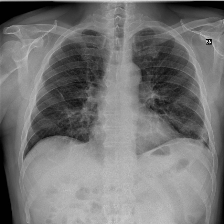

In [ ]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

# imagepath = './covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg'
imagepath = "assets/ex-covid.jpeg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

Instructions for updating:
non-resource variables are not supported in the long term


pred [[0.01225161 0.9877484 ]]
Prediction: positive
Confidence
Negative: 0.012 Positive: 0.988
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


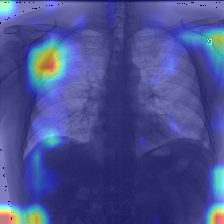

In [ ]:
import cv2 as cv
from sklearn.metrics import confusion_matrix
import numpy as np
import os, argparse

from google.colab.patches import cv2_imshow

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="post_relu/Relu"  
#post_relu/Relu,post_bn/cond/FusedBatchNorm, conv5_block3_out/add, conv5_block3_3_conv/convolution, conv5_block3_1_conv/convolution, conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


In [ ]:
# cv.imwrite(f'1-Relu-excovid_cam.jpg', dst_m)
# # dst_m write into folder

# change photo 10 times

In [ ]:
# func
def temp(saver, IMAGE_PATH, output_node_names = "norm_dense_2/Softmax",\
         final_conv_name="post_relu/Relu", model_path = 'models/COVIDNet-CXR-2/model',
         args_weightspath = 'models/COVIDNet-CXR-2',
         args_metaname = 'model.meta',args_ckptname = 'model',
         args_n_classes = 2, args_testfolder = 'data/test',
         args_in_tensorname_medusa = 'input_1:0', args_in_tensorname = 'input_1:0'
         ):

  with tf.Session() as sess:
      saver.restore(sess, model_path)  # load arguments using restore automatically
      img_m_0 = cv.imread(IMAGE_PATH)
      img_m_0 = cv.resize(img_m_0, (224, 224))
      
      if args_is_severity_model:
        # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
        mapping = {'level2': 0, 'level1': 1}
        inv_mapping = {0: 'level2', 1: 'level1'}
      elif args_n_classes == 2:
        # For COVID-19 positive/negative detection
        mapping = {'negative': 0, 'positive': 1}
        inv_mapping = {0: 'negative', 1: 'positive'}
      elif args_n_classes == 3:
        # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
        mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
        inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
      else:
        raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
            or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

      image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
      pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
      
      if args_is_medusa_backbone:
          x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
          x = x.astype('float32') / 255.0
          medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
          medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
          feed_dict = {
                      medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                      image_tensor: np.expand_dims(x, axis=0),
                  } 
          # print("args_is_medusa_backbone")
      else:
          x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
          x = x.astype('float32') / 255.0
          feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
          # print("Not args_is_medusa_backbone")
      pred = sess.run(pred_tensor, feed_dict=feed_dict)
      print("pred", pred)

      print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
      print('Confidence')
      print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))

      cam=grad_cam(prob_name=output_node_names, label=0, 
                    layer_name=final_conv_name, sess=sess, 
                    feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                    nb_classes=2)

      # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
      image_batch = img_m_0[None, :, :, :3]
      image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

      dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
      cv2_imshow(dst_m)

In [ ]:
# temp(saver, "./covid-chestxray-dataset-master/images/000001-1.jpg")

In [ ]:
# temp(saver, "./covid-chestxray-dataset-master/images/000002-1.jpg")

In [ ]:
# temp(saver, "./covid-chestxray-dataset-master/images/000003-1.jpg")

In [ ]:
# temp(saver, "./covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg")

In [ ]:
# temp(saver, "./covid-chestxray-dataset-master/images/000004-1.jpg")

In [ ]:
# temp(saver, "./covid-chestxray-dataset-master/images/000005-1.jpg")

In [ ]:
# temp(saver, "./covid-chestxray-dataset-master/images/000002-11-a.jpg")

In [ ]:
# temp(saver, "./covid-chestxray-dataset-master/images/000025-1.jpg")

In [ ]:
# temp(saver, "./covid-chestxray-dataset-master/images/000024-1.jpg")

make a folder and copy it into mydrive

In [ ]:
# !mkdir output

In [ ]:
# !mv '1-Relu-excovid_cam.jpg' 'output/'

# Comparation

## Load other dataset

In [ ]:
# covid-chestxray-dataset
!wget https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip

--2023-01-31 14:32:15--  https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master [following]
--2023-01-31 14:32:15--  https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [             <=>    ] 525.03M  18.9MB/s    in 28s     

2023-01-31 14:32:44 (18.5 MB/s) - ‘master.zip’ saved [550535079]



In [ ]:
!unzip master.zip

Archive:  master.zip
78543292f8b01d5e0ed1d0e15dce71949f0657bb
   creating: covid-chestxray-dataset-master/
   creating: covid-chestxray-dataset-master/.github/
 extracting: covid-chestxray-dataset-master/.github/FUNDING.yml  
   creating: covid-chestxray-dataset-master/.github/workflows/
  inflating: covid-chestxray-dataset-master/.github/workflows/tests.yml  
  inflating: covid-chestxray-dataset-master/.gitignore  
  inflating: covid-chestxray-dataset-master/README.md  
  inflating: covid-chestxray-dataset-master/SCHEMA.md  
   creating: covid-chestxray-dataset-master/annotations/
  inflating: covid-chestxray-dataset-master/annotations/covid-severity-scores.csv  
  inflating: covid-chestxray-dataset-master/annotations/imageannotation_ai_lung_bounding_boxes.json  
   creating: covid-chestxray-dataset-master/annotations/lungVAE-masks/
  inflating: covid-chestxray-dataset-master/annotations/lungVAE-masks/1-s2.0-S0140673620303706-fx1_lrg_mask.png  
  inflating: covid-chestxray-dataset-mas

## Test
- All the images highly might be detected as positive since they came from an *open dataset of chest X-ray and CT images of patients which are positive or suspected of COVID-19 or other viral and bacterial pneumonias* ([https://github.com/ieee8023/covid-chestxray-dataset/](https://github.com/ieee8023/covid-chestxray-dataset/)).

### 000001-1.jpg
- ./covid-chestxray-dataset-master/images/000001-1.jpg
- result for inference:
```
pred [[0.8663935  0.13360655]]
Prediction: negative
Confidence
Negative: 0.866 Positive: 0.134
```



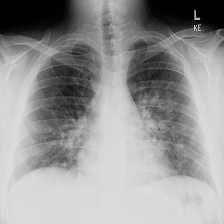

In [ ]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

imagepath = "./covid-chestxray-dataset-master/images/000001-1.jpg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

pred [[0.86639357 0.13360648]]
Prediction: negative
Confidence
Negative: 0.866 Positive: 0.134
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


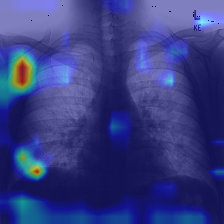

In [ ]:
import cv2 as cv
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import numpy as np
# import tensorflow as tf
import os, argparse

from google.colab.patches import cv2_imshow

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH = "./covid-chestxray-dataset-master/images/000001-1.jpg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="post_relu/Relu"  #conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
# saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


In [ ]:
# cv.imwrite(f'2-Relu-000001-1.jpg', dst_m)
# # dst_m write into folder

In [ ]:
# !mv '2-Relu-000001-1.jpg' 'output/'

### nejmoa2001191_f5-PA.jpeg
- ./covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg
- result for inference:
```
pred [[2.3010748e-06 9.9999774e-01]]
Prediction: positive
Confidence
Negative: 0.000 Positive: 1.000
```

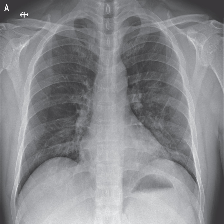

In [ ]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

imagepath = "./covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

pred [[2.3011428e-06 9.9999774e-01]]
Prediction: positive
Confidence
Negative: 0.000 Positive: 1.000
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


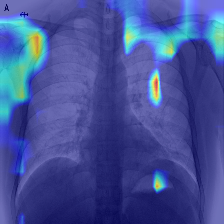

In [ ]:
import cv2 as cv
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import os, argparse

from google.colab.patches import cv2_imshow

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH ="./covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="post_relu/Relu"  #conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
# saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


In [ ]:
# cv.imwrite(f'3-Relu-nejmoa2001191_f5-PA.jpeg', dst_m)
# # dst_m write into folder

In [ ]:
# !mv '3-Relu-nejmoa2001191_f5-PA.jpeg' 'output/'

### 000002-1.jpg
- "./covid-chestxray-dataset-master/images/000002-1.jpg"
- result for inference:
```
pred [[0.00674177 0.99325824]]
Prediction: positive
Confidence
Negative: 0.007 Positive: 0.993
```

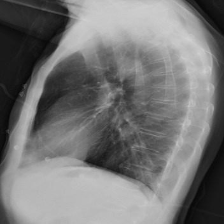

In [ ]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

imagepath = "./covid-chestxray-dataset-master/images/000002-1.jpg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

pred [[0.00674176 0.99325824]]
Prediction: positive
Confidence
Negative: 0.007 Positive: 0.993
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


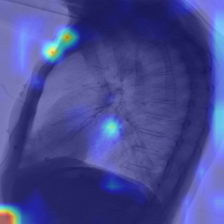

In [ ]:
import cv2 as cv
import tensorflow.compat.v1 as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import os, argparse

from google.colab.patches import cv2_imshow

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH ="./covid-chestxray-dataset-master/images/000002-1.jpg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="post_relu/Relu"  #conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
# saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


In [ ]:
# cv.imwrite(f'4-Relu-000002-1.jpg', dst_m)
# # dst_m write into folder

In [ ]:
# !mv '4-Relu-000002-1.jpg' 'output/'

### 000003-1.jpg
- "./covid-chestxray-dataset-master/images/000003-1.jpg"
- result for inference:
```
pred [[0.15814191 0.8418581 ]]
Prediction: positive
Confidence
Negative: 0.158 Positive: 0.842
```



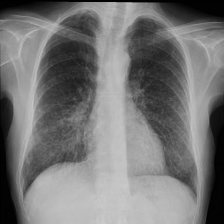

In [ ]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

imagepath = "./covid-chestxray-dataset-master/images/000003-1.jpg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

pred [[0.1581418  0.84185815]]
Prediction: positive
Confidence
Negative: 0.158 Positive: 0.842
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


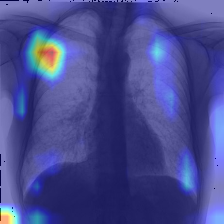

In [ ]:
import cv2 as cv
import tensorflow.compat.v1 as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import os, argparse

from google.colab.patches import cv2_imshow

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH ="./covid-chestxray-dataset-master/images/000003-1.jpg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="post_relu/Relu"  #conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
# saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


In [ ]:
# cv.imwrite(f'5-Relu-000003-1.jpg', dst_m)
# dst_m write into folder

In [ ]:
# !mv '5-Relu-000003-1.jpg' 'output/'

# Compare differing final layer of CNN

In [6]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from sklearn.metrics import confusion_matrix
import os, argparse

from google.colab.patches import cv2_imshow
def show_org(IMAGE_PATH):
  imagepath = IMAGE_PATH
  img_m = cv.imread(imagepath)
  img_m = cv.resize(img_m, (224, 224))
  # display(Image(imagepath))
  cv2_imshow(img_m)
  

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def main_grad_cam(IMAGE_PATH, MODEL_NAME):
  # arguments:
  IMAGE_PATH = IMAGE_PATH
  output_node_names = "norm_dense_2/Softmax" #dense_3/Softmax:0
  final_conv_name="conv5_block3_out/add:0"  #conv5_block3_1_conv/convolution, conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
  model_path = MODEL_NAME

  # USE COVIDNet CXR 2
  args_weightspath = 'models/COVIDNet-CXR-2' 
  args_metaname = 'model.meta'
  args_ckptname = 'model'
  args_n_classes = 2

  args_testfolder = 'data/test'
  args_trainfile = 'labels/train_COVIDx9B.txt'
  args_testfile = 'labels/test_COVIDx9B.txt'

  args_out_tensorname = 'norm_dense_2/Softmax:0' #dense_3/Softmax:0
  args_logit_tensorname = 'norm_dense_2/MatMul:0'
  args_is_severity_model = False
  args_is_medusa_backbone = False

  args_in_tensorname = 'input_1:0'
  args_in_tensorname_medusa = 'input_1:0'
  args_input_size = 480
  args_input_size_medusa = 256
  args_top_percent = 0.08

  # ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
  saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

  with tf.Session() as sess:
      saver.restore(sess, model_path)  # load arguments using restore automatically


      img_m_0 = cv.imread(IMAGE_PATH)
      img_m_0 = cv.resize(img_m_0, (224, 224))
      # img_m = tf.cast(img_m_0, tf.float32)
      # img_m = tf.reshape(img_m, [224, 224, 3])
      # img_m_f= sess.run([img_m])
      # print("img_m4", img_m)  # shape 480,480,3
      # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

      '''
      /////////////////////////////////////////// inference related
      '''
      
      if args_is_severity_model:
        # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
        mapping = {'level2': 0, 'level1': 1}
        inv_mapping = {0: 'level2', 1: 'level1'}
      elif args_n_classes == 2:
        # For COVID-19 positive/negative detection
        mapping = {'negative': 0, 'positive': 1}
        inv_mapping = {0: 'negative', 1: 'positive'}
      elif args_n_classes == 3:
        # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
        mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
        inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
      else:
        raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
            or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

      '''
      \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
      '''

      image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
      pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
      
      if args_is_medusa_backbone:
          x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
          x = x.astype('float32') / 255.0
          medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
          medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
          feed_dict = {
                      medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                      image_tensor: np.expand_dims(x, axis=0),
                  } 
          # print("args_is_medusa_backbone")
      else:
          x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
          x = x.astype('float32') / 255.0
          feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
          # print("Not args_is_medusa_backbone")
      pred = sess.run(pred_tensor, feed_dict=feed_dict)
      print("pred", pred)

      print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
      print('Confidence')
      print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
      print('**DISCLAIMER**')
      print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

      
      # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
      # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

      # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
      # x = x.astype('float32') / 255.0
      # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
      # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

      cam=grad_cam(prob_name=output_node_names, label=0, 
                    layer_name=final_conv_name, sess=sess, 
                    feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                    nb_classes=2)

      # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
      image_batch = img_m_0[None, :, :, :3]
      image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

      dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
      cv2_imshow(dst_m)
      # cv.imshow('dst_m_v',dst_m)
      cv.waitKey(0)




# save output files into MyDrive


In [ ]:
# !cp -r 'output/' 'drive/MyDrive/covid'

# Test2

In [1]:
import cv2 as cv
# import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import os, argparse

from google.colab.patches import cv2_imshow

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # img = cv.resize(img, (224, 224))
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "dense_3/Softmax:0" #norm_dense_2/Softmax
final_conv_name="conv5_block3_3_conv/BiasAdd"  
'''
#conv5_block3_1_conv/convolution, post_relu/Relu,post_bn/cond/FusedBatchNorm, 
#conv5_block3_out/add, conv5_block3_3_conv/convolution, conv5_block3_1_conv/convolution, 
#conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
'''
model_path = 'models/COVIDNet-CXR-Large/model' #models/COVIDNet-CXR-2/model
model_path2 = 'models/COVIDNet-CXR-Large/model-8485'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-Large/' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'dense_3/Softmax:0' #norm_dense_2/Softmax:0
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 224
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path2)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    print("img_m_0", img_m_0.shape)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('dense_3/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}

        print("x - shape", x.shape)
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


Instructions for updating:
non-resource variables are not supported in the long term


img_m_0 (224, 224, 3)
x - shape (224, 224, 3)
pred [[0.0093155  0.00581197 0.98487246]]


KeyError: ignored

In [6]:
pred_tensor

<tf.Tensor 'dense_3/Softmax:0' shape=(?, 3) dtype=float32>

In [4]:
# feed_dict

In [5]:
# cv.imwrite(f'conv5_block3_1_conv_convolution-excovid.jpg', dst_m)
# # dst_m write into folder

In [ ]:
# !mv 'conv5_block3_1_conv_convolution-excovid.jpg' 'output/'

# Test3
## for new final layer 
- update final layer name with 'conv5_block3_3_conv/BiasAdd:0'
- output tensor: dense_3/Softmax:0
- use code
[https://gist.github.com/nguyenhoa93/d49564875234f6722ff89e65db34a00b](https://https://gist.github.com/nguyenhoa93/d49564875234f6722ff89e65db34a00b)

In [1]:
"""
Generate GradCAM for COVID-Net model: https://github.com/lindawangg/COVID-Net
By: Hoa Nguyen
Last updated: May 23, 2020
"""
# Dependencies
import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import os, argparse
import cv2
import pandas as pd
from tqdm import tqdm
import json
tf.disable_v2_behavior()

# parser = argparse.ArgumentParser(description='COVID-Net Inference')
# parser.add_argument('-model', default="COVID-Net-Small.json", help="Path to model specification")
# parser.add_argument('-impath', default='./data/test', help='Path to image')
# parser.add_argument('-pred_class', help='Prediction result by COVID-Net. Should be: normal | pneumonia | COVID-19')
# parser.add_argument('-outdir', help="Output directory")

# args = parser.parse_args()
# model_info = json.load(open(args.model))

# weightspath = model_info["weightspath"]
# metaname = model_info["metaname"]
# ckptname = model_info["ckptname"]
weightspath = 'models/COVIDNet-CXR-Large/' 
  
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "dense_3/Softmax:0" #norm_dense_2/Softmax
final_conv_name="conv5_block3_3_conv/BiasAdd:0"  
'''
#conv5_block3_1_conv/convolution, post_relu/Relu,post_bn/cond/FusedBatchNorm, 
#conv5_block3_out/add, conv5_block3_3_conv/convolution, conv5_block3_1_conv/convolution, 
#conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
'''
model_path = 'models/COVIDNet-CXR-Large/model' #models/COVIDNet-CXR-2/model
model_path2 = 'models/COVIDNet-CXR-Large/model-8485'


metaname = 'model.meta'
ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'dense_3/Softmax:0' #norm_dense_2/Softmax:0
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 224 # 480
args_input_size_medusa = 256
args_top_percent = 0.08

# save image
args_impath = "assets/ex-covid.jpeg"
args_pred_class = 'COVID-19'
args_outdir = './'

mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]


def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, top_percent, size):
    if filepath.split(".")[-1] == "npy":
        x_arr = np.load(filepath)
        x_arr = x_arr * 255.0 / x_arr.max()
        img = np.stack((x_arr, x_arr, x_arr), axis=-1)
    else:
        img = cv2.imread(filepath)

    processed_img = crop_top(img, percent=top_percent)
    processed_img = central_crop(processed_img)
    processed_img = cv2.resize(processed_img, (size, size))
    return processed_img, img
  
class GradCAM:
    def __init__(self, graph, classes, outLayer, targetLayer=None):
        self.graph = graph
        self.classes = classes
        self.targetLayer = targetLayer
        self.outLayer = outLayer

        if self.targetLayer is None:
            self.target = self.find_target_tensor()
        else:
            self.target = self.graph.get_tensor_by_name(self.targetLayer)

    def find_target_tensor(self):
        """
        Find the last tensor that have 4D shape if targetLayer is not specified.
        :return:
        """
        tensor_names = [t.name for op in tf.get_default_graph().get_operations() for t in op.values() if
                   "save" not in str(t.name)]
        for tensor_name in reversed(tensor_names):
            tensor = self.graph.get_tensor_by_name(tensor_name)
            if len(tensor.shape) == 4:
                return tensor

        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")

    def compute_grads(self):
        results = {} # grads of classes with keys being classes and values being normalized gradients
        for classIdx in self.classes:
            one_hot = tf.sparse_to_dense(classIdx, [len(self.classes)], 1.0)
            signal = tf.multiply(self.graph.get_tensor_by_name(self.outLayer),one_hot)
            loss = tf.reduce_mean(signal)

            grads = tf.gradients(loss, self.target)[0]

            norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads)))+tf.constant(1e-5))

            results[classIdx] = norm_grads

        return results


def generate_cam(conv_layer_out, grads_val, upsample_size):
    weights = np.mean(grads_val, axis=(0,1))
    cam = np.zeros(conv_layer_out.shape[0:2], dtype=np.float32)

    # Weight averaginng
    for i, w in enumerate(weights):
        cam += w*conv_layer_out[:,:,i]

    # Apply reLU
    cam = np.maximum(cam, 0)
    cam = cam/np.max(cam)
    cam = cv2.resize(cam, upsample_size)

    # Convert to 3D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3



# if __name__ == '__main__':
sess = tf.Session()
# tf.get_default_graph()
# saver = tf.train.import_meta_graph(os.path.join(weightspath, metaname))
saver = tf.train.import_meta_graph(model_path + '.meta')
# saver.restore(sess, os.path.join(weightspath, ckptname))
# saver.restore(sess, weightspath)
saver.restore(sess, model_path2)

graph = tf.get_default_graph()

image_tensor = graph.get_tensor_by_name(args_in_tensorname)
gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

grads = gradCam.compute_grads()

x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
img_arr = np.asanyarray(x)
size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

x = x.astype('float32') / 255.0
output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

cam3 = generate_cam(output[0],grads_val[0],size_upsample)

# Overlay cam on image
cam3 = np.uint8(255*cam3)
cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)

new_im = cam3*0.3 + origin_im*0.5

im_name = args_impath.split("/")[-1]
ext = im_name.split(".")[-1]

# Save the GradCAM
cv2.imwrite(os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

print("GradCAM image is save in ", args_outdir)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


GradCAM image is save in  ./


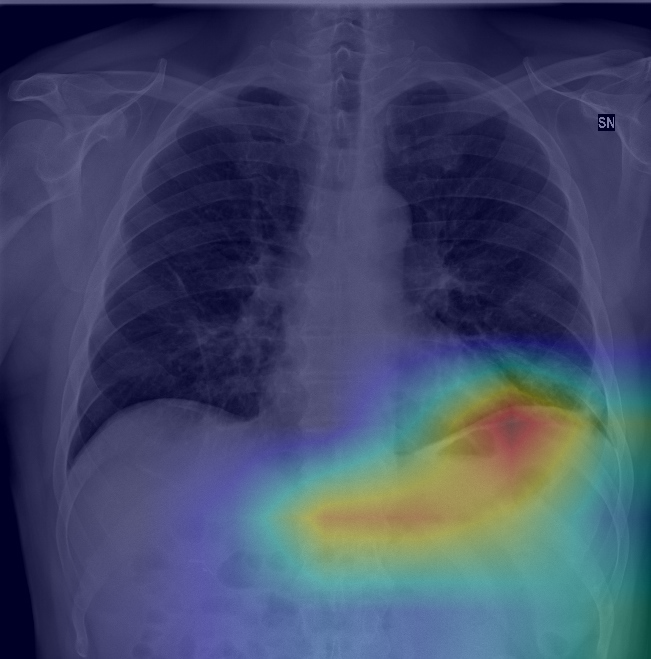

In [3]:
from google.colab.patches import cv2_imshow
cv2_imshow(new_im)

In [7]:
# save into google drive
!cp -r '/content/COVID-19_ex-covid.png' 'drive/MyDrive/covid/output'

# RISE


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

In [ ]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

In [ ]:
from keras.preprocessing import image

In [ ]:
def load_img(path):
    img = tf.keras.utils.load_img(path, target_size=model.input_size)
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    return masks

In [ ]:
batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1
    return sal

In [ ]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [ ]:
model = Model()

/usr/local/lib/python3.8/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
print(model)

In [ ]:
img, x = load_img('assets/ex-covid.jpeg')

In [ ]:
N = 2000
s = 8
p1 = 0.5
masks = generate_masks(2000, 8, 0.5)

Generating masks: 100%|██████████| 2000/2000 [00:13<00:00, 152.60it/s]


In [ ]:
sal = explain(model, x, masks)

Explaining:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
Explaining: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


35363/35363 [==============================] - 0s 0us/step


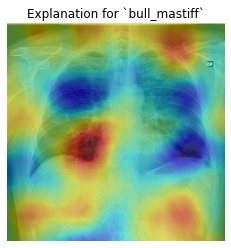

In [ ]:
class_idx = 243
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()